In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv('diabetes_binary_1.csv')

# df = pd.read_csv("diabetes_ver2.csv")

# standardize "BMI", "GenHlth", "MentHlth", "PhysHlth", "Age", "Education", "Income"
df["BMI"] = (df["BMI"] - df["BMI"].mean()) / df["BMI"].std()
df["GenHlth"] = (df["GenHlth"] - df["GenHlth"].mean()) / df["GenHlth"].std()
df["MentHlth"] = (df["MentHlth"] - df["MentHlth"].mean()) / df["MentHlth"].std()
df["PhysHlth"] = (df["PhysHlth"] - df["PhysHlth"].mean()) / df["PhysHlth"].std()
df["Age"] = (df["Age"] - df["Age"].mean()) / df["Age"].std()
df["Education"] = (df["Education"] - df["Education"].mean()) / df["Education"].std()
df["Income"] = (df["Income"] - df["Income"].mean()) / df["Income"].std()


train = df[df['fold'].isin(range(1, 8))]
test = df[df['fold'] == 10]
tune = df[df['fold'] == 8]

train = train.drop("fold", axis=1)
test = test.drop("fold", axis=1)
tune = tune.drop("fold", axis=1)


x_train = train.drop("Diabetes_binary", axis=1)
y_train = train["Diabetes_binary"]
x_test = test.drop("Diabetes_binary", axis=1)
y_test = test["Diabetes_binary"]
x_tune = tune.drop("Diabetes_binary", axis=1)
y_tune = tune["Diabetes_binary"]

# standardize the data
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()
x_tune = (x_tune - x_tune.mean()) / x_tune.std()


x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_tune = np.array(x_tune)
y_tune = np.array(y_tune)


In [3]:
print(df.shape)

(70692, 23)


In [4]:
from sklearn import svm
import joblib

# Assuming you have already trained your SVM model
clf = svm.SVC(kernel='linear', C=1, gamma='auto')
clf.fit(x_train, y_train)

# Save the trained model to a file
joblib.dump(clf, 'svm_model1.pkl')


['svm_model1.pkl']

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib


clf = joblib.load('svm_model1.pkl')
y_pred = clf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1:", f1_score(y_test, y_pred, average='macro'))


Accuracy: 0.8639001510453931
Precision: 0.43195007552269654
Recall: 0.5
F1: 0.4634905740851318


/Users/yl/Library/Caches/pypoetry/virtualenvs/slml-JC0Nopl2-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[2476 1026]
 [ 741 2903]]


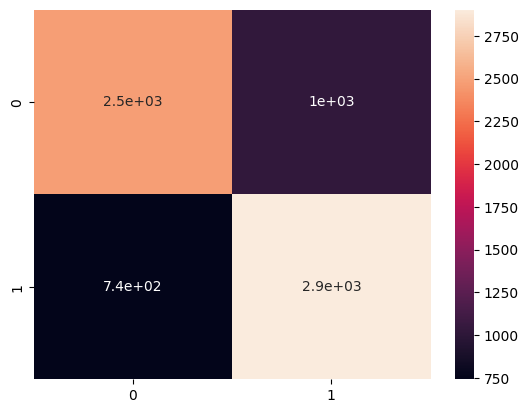

In [6]:
# draw heatmap of accuracy of best SVM model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True)
plt.show()

# save cm into csv
import csv
with open('heatmap/SVM_b1.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(cm)
    

0.8249394183408446


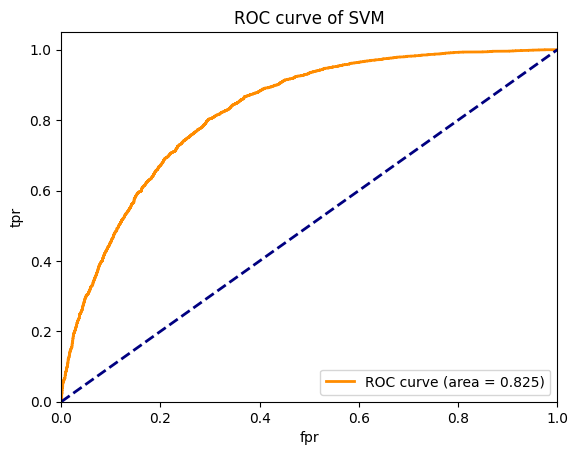

In [7]:
# draw ROC curve of best SVM model, and save ROC curve data into csv
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred = clf.decision_function(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve of SVM')
plt.legend(loc="lower right")
plt.show()

# save ROC curve data into csv, write each value into one column
import pandas as pd

# Create a DataFrame from the TPR, FPR, and Thresholds
roc_data = pd.DataFrame({
    'TPR': tpr,
    'FPR': fpr,
    'Thresholds': thresholds
})

# Save the DataFrame to a CSV file
roc_data.to_csv('ROC/SVM_b1.csv', index=False)

In [8]:
# get parameterns of best SVM model
print(clf.get_params())

# get weight of each feature of best SVM model, with the same order as in the dataset, and with feature names
import pandas as pd
import numpy as np

df = pd.read_csv('diabetes_binary_1.csv')
df = df.drop("fold", axis=1)
x_train = df.drop("Diabetes_binary", axis=1)
feature_names = list(x_train.columns.values)
print(feature_names)
print(clf.coef_)
print(clf.intercept_)

# map feature names to weights
feature_weight = {}
for i in range(len(feature_names)):
    feature_weight[feature_names[i]] = clf.coef_[0][i]
print(feature_weight)

# save feature weights into csv
import csv
with open('feature_weight/SVM_b1.csv', 'w') as f:
    writer = csv.writer(f)
    for key, value in feature_weight.items():
        writer.writerow([key, value])


{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
[[ 0.37600989  0.23360685  0.16440517  0.42047905  0.00693593  0.02225315
   0.07594148 -0.01113205 -0.0006653  -0.02435445 -0.1453853   0.0102078
   0.01260952  0.52453581 -0.03865735 -0.07761941  0.03586539  0.08747957
   0.33052137 -0.02912478 -0.10850282]]
[0.03919867]
{'HighBP': 0.3760098949898172, 'HighChol': 0.23360684705362567, 'CholCheck': 0.164405174981042, 'BMI': 0.42047904800384583, 'Smoker': 0.006935928570898753, 'Stroke': 0.02225315307944342

In [7]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(x_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [70692, 56600]

In [12]:
import pandas as pd
import numpy as np
import io

df = pd.read_csv('diabetes_binary_2.csv')

# standardize "BMI", "GenHlth", "MentHlth", "PhysHlth", "Age", "Education", "Income"
df["BMI"] = (df["BMI"] - df["BMI"].mean()) / df["BMI"].std()
df["GenHlth"] = (df["GenHlth"] - df["GenHlth"].mean()) / df["GenHlth"].std()
df["MentHlth"] = (df["MentHlth"] - df["MentHlth"].mean()) / df["MentHlth"].std()
df["PhysHlth"] = (df["PhysHlth"] - df["PhysHlth"].mean()) / df["PhysHlth"].std()
df["Age"] = (df["Age"] - df["Age"].mean()) / df["Age"].std()
df["Education"] = (df["Education"] - df["Education"].mean()) / df["Education"].std()
df["Income"] = (df["Income"] - df["Income"].mean()) / df["Income"].std()

train = df[df['fold'].isin(range(1, 9))]
test = df[df['fold'] == 10]

train = train.drop("fold", axis=1)
test = test.drop("fold", axis=1)

x_train = train.drop("Diabetes_binary", axis=1)
y_train = train["Diabetes_binary"]
x_test = test.drop("Diabetes_binary", axis=1)
y_test = test["Diabetes_binary"]

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [26]:
print(df.shape)

(253680, 23)


In [19]:
from sklearn import svm
import joblib

# Assuming you have already trained your SVM model
clf = svm.SVC(kernel='linear', C=1, gamma='auto')
clf.fit(x_train, y_train)

# Save the trained model to a file
joblib.dump(clf, 'svm_model2.pkl')


ValueError: Found input variables with inconsistent numbers of samples: [70692, 203172]

In [28]:
# draw heatmap of accuracy of best SVM model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True)
plt.show()

# save cm into csv
import csv
with open('heatmap/SVM_b2.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(cm)
    

/Users/yl/Library/Caches/pypoetry/virtualenvs/slml-JC0Nopl2-py3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


AttributeError: 'SVC' object has no attribute 'support_vectors_'

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib


clf = joblib.load('svm_model2.pkl')
y_pred = clf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.8639001510453931
Precision: 0.43195007552269654
Recall: 0.5
F1: 0.4634905740851318


/Users/yl/Library/Caches/pypoetry/virtualenvs/slml-JC0Nopl2-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5
[[21734     0]
 [ 3424     0]]


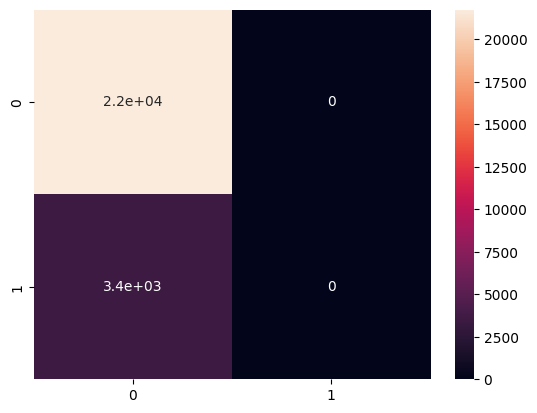

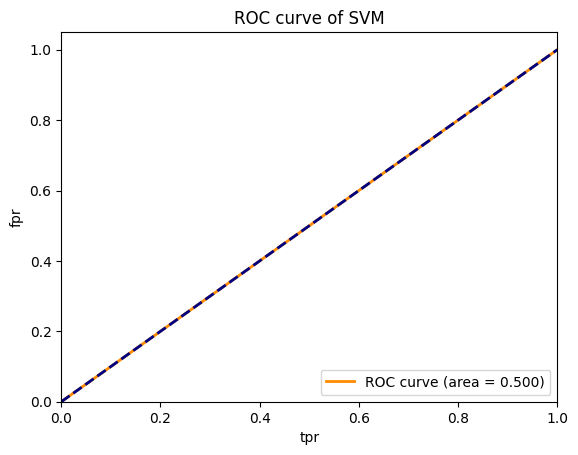

In [38]:
# draw ROC curve of best SVM model, and save ROC curve data into csv
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred = clf.decision_function(x_test)
# turn into binary
y_pred = np.where(y_pred > 0, 1, 0)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# plot heat map
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True)
plt.show()


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('ROC curve of SVM')
plt.legend(loc="lower right")
plt.show()

# save ROC curve data into csv, write each value into one column
import pandas as pd

# Create a DataFrame from the TPR, FPR, and Thresholds
roc_data = pd.DataFrame({
    'TPR': tpr,
    'FPR': fpr,
    'Thresholds': thresholds
})

# Save the DataFrame to a CSV file
roc_data.to_csv('ROC/SVM_b2.csv', index=False)

In [37]:
print(y_pred)


[-0.99988756 -0.99995834 -1.00012039 ... -0.99999215 -1.00011272
 -1.00004569]


In [14]:
# get parameterns of best SVM model
print(clf.get_params())

# get weight of each feature of best SVM model, with the same order as in the dataset, and with feature names
import pandas as pd
import numpy as np

df = pd.read_csv('diabetes_binary_1.csv')
df = df.drop("fold", axis=1)
x_train = df.drop("Diabetes_binary", axis=1)
feature_names = list(x_train.columns.values)
print(feature_names)
print(clf.coef_)
print(clf.intercept_)

# map feature names to weights
feature_weight = {}
for i in range(len(feature_names)):
    feature_weight[feature_names[i]] = clf.coef_[0][i]
print(feature_weight)

# save feature weights into csv
import csv
with open('feature_weight/SVM_b2.csv', 'w') as f:
    writer = csv.writer(f)
    for key, value in feature_weight.items():
        writer.writerow([key, value])


{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
[[ 7.57841663e-05  6.64977269e-05  1.04834649e-04  8.49623477e-05
   9.46418368e-06 -4.63089350e-05  4.09351023e-05 -2.35140251e-05
  -1.26594823e-05 -8.51193545e-06 -7.25807128e-05  1.34661204e-05
  -1.55771409e-05  5.84805294e-05 -2.30218268e-05 -8.51892959e-06
  -3.26623376e-06  2.91043580e-05 -3.59534980e-05  8.10172365e-06
   4.01765981e-06]]
[-1.00020105]
{'HighBP': 7.578416625619866e-05, 'HighChol': 6.649772694800049e-05, 'CholCheck': 0.00010483464

[[3484   18]
 [   0 3644]]
F1 Macro Score: 0.9974798449113629


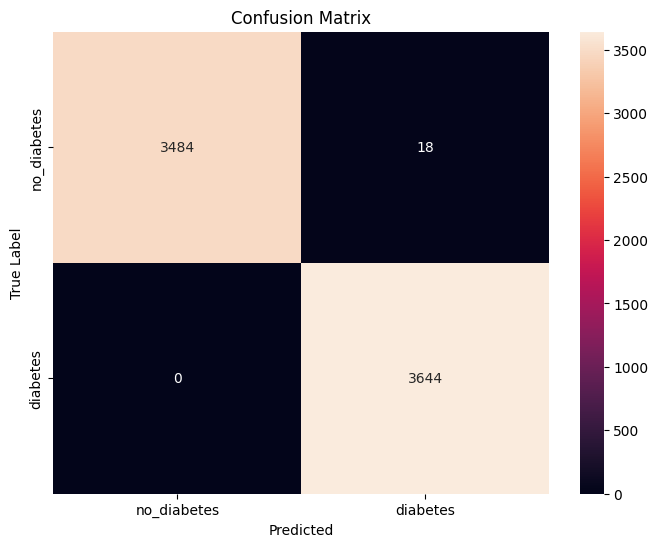

In [18]:
# draw heatmap of accuracy of best SVM model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

cm = [[3484, 18],[0, 3644]]
# cm = cm transpose
cm = np.array(cm)
# cm = cm.transpose()
print(cm)
# Show original number instead of scientific notation
# save the plot
import matplotlib.pyplot as plt
index = ["no_diabetes", "diabetes"]
columns = ["no_diabetes", "diabetes"]
# change 0, 1 into "no_diabetes", "diabetes"
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.savefig('heatmap/SVM_b3.png')

# calculate f1 score from confusion matrix
# calculate F1 score through confusion matrix, without y_test and y_pred, using macro average  
import numpy as np

# Replace this 2x2 array with your confusion matrix values
# cm = np.array([[true_negative, false_negative],
#                         [false_positive, true_positive]])

# Calculate precision, recall, and F1 for each class
precision_class0 = cm[0, 0] / np.sum(cm[0, :])
recall_class0 = cm[0, 0] / np.sum(cm[:, 0])
f1_class0 = 2 * (precision_class0 * recall_class0) / (precision_class0 + recall_class0)

precision_class1 = cm[1, 1] / np.sum(cm[1, :])
recall_class1 = cm[1, 1] / np.sum(cm[:, 1])
f1_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1)

# Calculate F1 Macro Score
f1_macro = (f1_class0 + f1_class1) / 2
print("F1 Macro Score:", f1_macro)


plt.show()


[[3484   18]
 [   0 3644]]
F1 Macro Score: 0.9974798449113629


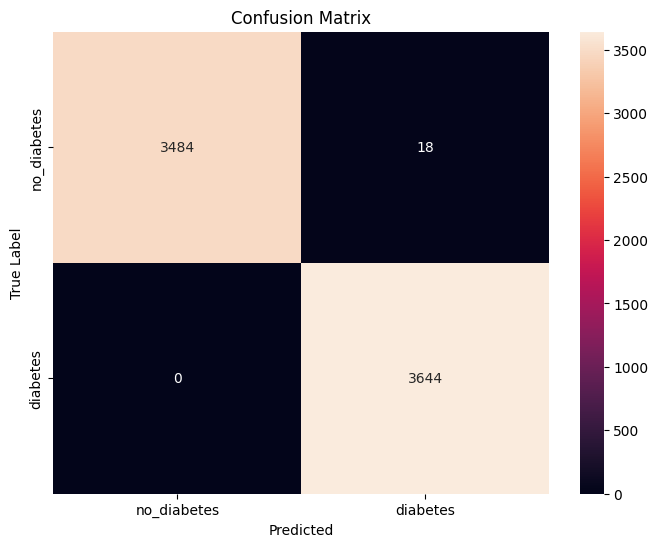

In [ ]:
# draw heatmap of accuracy of best SVM model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

cm = [[3484, 18],[0, 3644]]
# cm = cm transpose
cm = np.array(cm)
# cm = cm.transpose()
print(cm)
# Show original number instead of scientific notation
# save the plot
import matplotlib.pyplot as plt
index = ["no_diabetes", "diabetes"]
columns = ["no_diabetes", "diabetes"]
# change 0, 1 into "no_diabetes", "diabetes"
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.savefig('heatmap/SVM_b3.png')

# calculate f1 score from confusion matrix
# calculate F1 score through confusion matrix, without y_test and y_pred, using macro average  
import numpy as np

# Replace this 2x2 array with your confusion matrix values
# cm = np.array([[true_negative, false_negative],
#                         [false_positive, true_positive]])

# Calculate precision, recall, and F1 for each class
precision_class0 = cm[0, 0] / np.sum(cm[0, :])
recall_class0 = cm[0, 0] / np.sum(cm[:, 0])
f1_class0 = 2 * (precision_class0 * recall_class0) / (precision_class0 + recall_class0)

precision_class1 = cm[1, 1] / np.sum(cm[1, :])
recall_class1 = cm[1, 1] / np.sum(cm[:, 1])
f1_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1)

# Calculate F1 Macro Score
f1_macro = (f1_class0 + f1_class1) / 2
print("F1 Macro Score:", f1_macro)


plt.show()


['ROC/categoricalnb_b1 (1).csv', 'ROC/logistic_with_regularization_b2.csv', 'ROC/logistic_with_regularization_b1.csv', 'ROC/rf_stack_b2.csv', 'ROC/KNN_b1.csv', 'ROC/rf_stack_b1.csv', 'ROC/KNN_b2.csv', 'ROC/SVM_b1.csv', 'ROC/SVM_b2.csv', 'ROC/categoricalnb_b2 (1).csv', 'ROC/categoricalnb_b2.csv', 'ROC/random_forest_b2.csv', 'ROC/log_stack_b1.csv', 'ROC/categoricalnb_b1.csv', 'ROC/random_forest_b1.csv', 'ROC/log_stack_b2.csv']
ROC/categoricalnb_b1 (1).csv
ROC/logistic_with_regularization_b2.csv
ROC/logistic_with_regularization_b1.csv
ROC/rf_stack_b2.csv
ROC/KNN_b1.csv
ROC/rf_stack_b1.csv
ROC/KNN_b2.csv
ROC/SVM_b1.csv
ROC/SVM_b2.csv
ROC/categoricalnb_b2 (1).csv
ROC/categoricalnb_b2.csv
ROC/random_forest_b2.csv
ROC/log_stack_b1.csv
ROC/categoricalnb_b1.csv
ROC/random_forest_b1.csv
ROC/log_stack_b2.csv


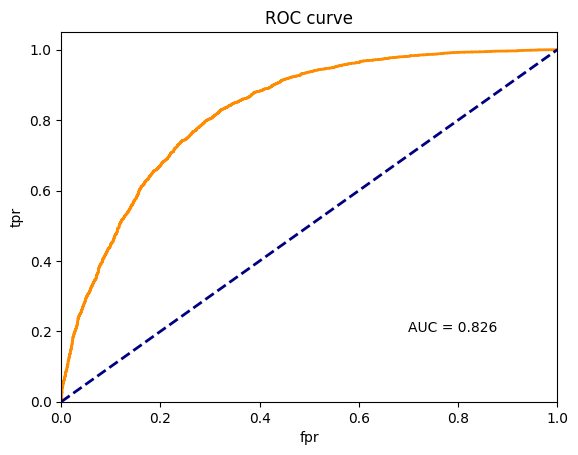

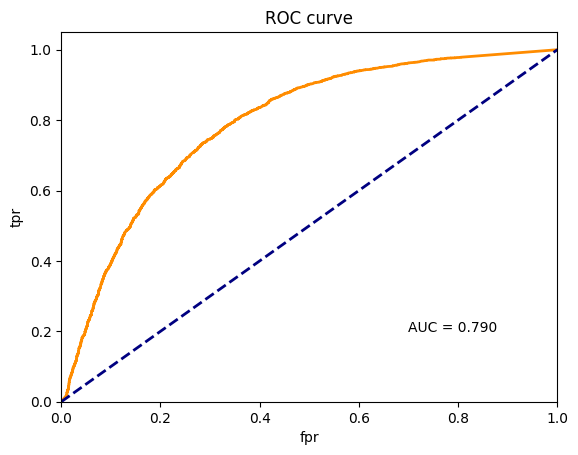

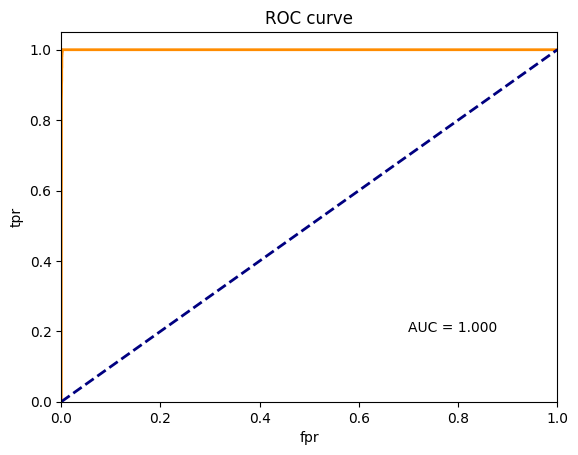

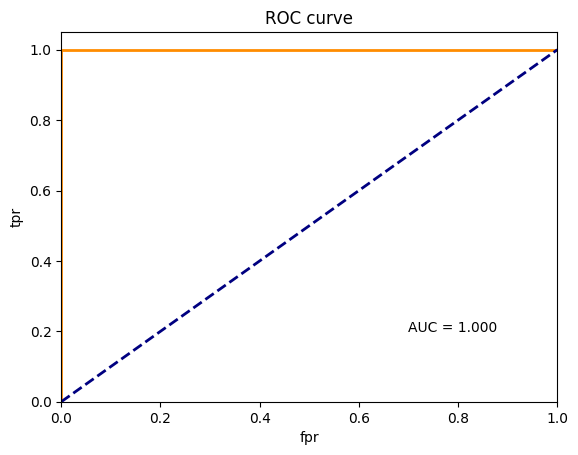

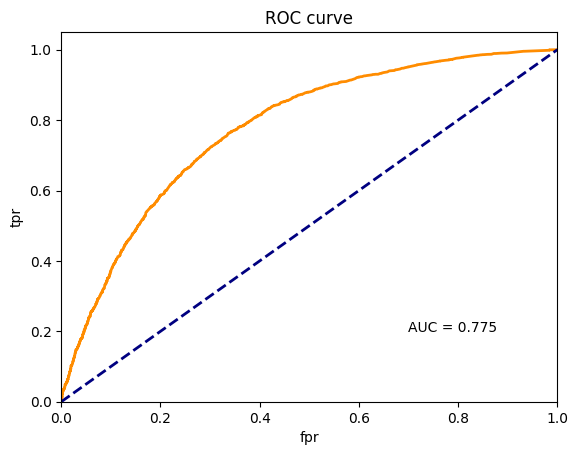

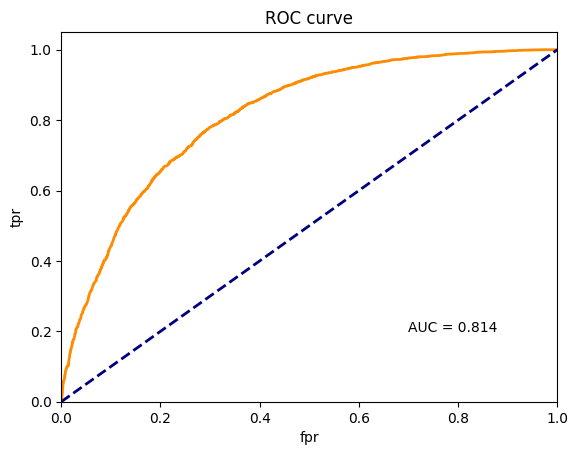

In [16]:
# read ROC curve data from csv
import pandas as pd
import numpy as np
import io
# draw ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# read ROC folder, get all csv files
import os
import glob
import pandas as pd
from sklearn.metrics import roc_curve, auc


path = r'ROC'
all_files = glob.glob(os.path.join(path, "*.csv"))
print(all_files)

for file in all_files:
    # file = "ROC/random_forest_b1.csv"
    # get only b1.csv only
    print(file)
    if file[-6:] != "b1.csv":
        continue
    if file[4:7] == "SVM":
        continue

    df = pd.read_csv(file)
    y_prob = df['diabetes_prob']
    y_prob = np.array(y_prob)
    y_test = np.array(y_test)
    y_test = y_test.reshape(-1, 1)
    y_prob = y_prob.reshape(-1, 1)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve')
    plt.text(0.7, 0.2, f'AUC = {format(roc_auc, ".3f")}')
    plt.savefig(file[:-4] + ".png")

